# Assignment 6: Neural network

## BUS 20800: Big Data
## Due: 11:59 am on Feb 26, 2024

This assignment is a simplified exercise based on the simulations in this paper: 
[Empirical Asset Pricing via Machine Learning](https://dachxiu.chicagobooth.edu/download/ML.pdf).

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import os

%matplotlib inline

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
path = '/classes/20800_winter2024/Data/Simu/'

# Part I. DGP

You can check the data generating process in `DGP.py`. We have generated firm characteristics and returns as linear and nonlinear functions of these characteristics, respectively.


It takes several minutues to run the simulation code and generate the data, if you want to run it yourself. We have provided the simulated data for you. You can check the simulated data in `Simu` folder. There are 100 Monte Carlo repetions.

# Part II. Two Layer NN

First, follow the instruction codes in lecture codes, finish this toy `TwoLayerNet` class for rergression.

In [60]:
X = np.array([[1,2,3],[2,3,4]])
W = np.array([[10,10],[20,20],[30,30]])
print("X dimensions", X.shape)
print("W dimensions", W.shape)
print(X.dot(W))
print(X@W)

X dimensions (2, 3)
W dimensions (3, 2)
[[140 140]
 [200 200]]
[[140 140]
 [200 200]]


In [61]:
b1 = np.array([[1,2,3,4]]) # H*1 = 4*1
W1 = np.array([[1,2,3,4],[1,2,3,4]]) # D*H = 2*4
X = np.array([[1,2],[1,2],[1,2]]) # N*D = 3*2

np.dot(X,W1)
X.dot(W1)+b1
b1.shape[1]

4

In [62]:


# Calculate the identity function
dHdb1 = np.zeros(b1.shape[1])
for i in range((np.dot(X,W1)+b1).shape[0]):
    if np.linalg.norm(np.dot(X,W1)+b1) > 0:
        dHdb1[i] = 1
    else:
        dHdb1[i] = 0

print(dHdb1)

[1. 1. 1. 0.]


In [63]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs regression task.
    
    We train the network with square loss and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - square loss

    The outputs of the second fully-connected layer are the predictions.
    """
    
    
    # Initialize the NN
    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; Shape (D, H)
        b1: First layer biases; Shape (H,)
        W2: Second layer weights; Shape (H, 1)
        b2: Second layer biases; Shape (1,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: Output prediction.
        """
        
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def loss(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels.
        - reg: Regularization strength.

        Returns:
        If y is None, return a matrix scores of shape (N, 1) where scores[i,0] is
        the prediction.

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization penalty) 
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Compute the forward pass
        # Use Relu as the non-linearity function
        scores = np.maximum(X.dot(W1) + b1, 0).dot(W2) + b2


        # If the targets are not given then jump out, we're done
        if y is None:
            return scores
        
##############################################################################
### TODO: Calculate the loss function (data + regularization)              ###
##############################################################################
        # Compute the loss
        loss = np.mean((scores - y)**2) # Mean squared error 
        # Add regularization loss
        loss  += reg * (np.sum(W1 ** 2) + np.sum(W2 ** 2))
##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################

        
        
        # Backward pass: compute gradients
        grads = {}            
##############################################################################
### TODO: Calculate the gradient of each parameter.                        ###
##############################################################################
        hidden_layer = np.maximum(0, X.dot(W1) + b1)  # ReLU activation
        dloss = 2 * (scores - y) / X.shape[0]  
        grads['b2'] = np.sum(dloss, axis=0)
        grads['W2'] = hidden_layer.T.dot(dloss) + 2 * reg * W2 
        dhidden = dloss.dot(W2.T)
        dhidden[hidden_layer <= 0] = 0  # Indicator function 

        grads['b1'] = np.sum(dhidden, axis=0)  
        grads['W1'] = X.T.dot(dhidden) + 2 * reg * W1 
##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################
        
        return loss, grads

    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, learning_rate_decay=0.95,
              reg=5e-6, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this neural network using SGD.

        Inputs:
        - X: Shape (N, D) 
        - y: Shape (N, )
        - X_val: Shape (N_val, D) 
        - y_val: Shape (N_val, ) 
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = None
            y_batch = None

            mask  = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[mask]
            y_batch = y[mask]

            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            # Gradient descent 
##############################################################################
### TODO: Perform Gradient descent to update parameters                                    ###
##############################################################################
##############################################################################
            self.params['b1']  += -learning_rate*grads['b1']
            self.params['W1']  += -learning_rate*grads['W1']
            self.params['b2']  += -learning_rate*grads['b2']
            self.params['W2']  += -learning_rate*grads['W2']

##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict return for
        data points.
        Inputs:
        - X: Shape (N, D)

        Returns:
        - y_pred: Shape (N,)
        """

        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        
##############################################################################
### TODO: Calculate the prediction.                                        ###
##############################################################################
        scores = np.maximum(X.dot(W1) + b1, 0).dot(W2) + b2
        y_pred = np.argmax(scores,axis = 1)

##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################
        
        return y_pred



In [64]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
output_size = 1
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, output_size, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1]).reshape(-1,1)
    return X, y

net = init_toy_model()
X, y = init_toy_data()

## Forward pass: compute scores
Open the file `neural_net.py` and look at the method `TwoLayerNet.loss`. It takes the data and weights and computes the class scores, the loss, and the gradients with respect to the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [65]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [0.38061523],
  [-0.55607245],
  [-0.59991751],
  [-0.61246639],
  [0.05788525]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[ 0.38061523]
 [-0.55607245]
 [-0.59991751]
 [-0.61246639]
 [ 0.05788525]]

correct scores:
[[ 0.38061523]
 [-0.55607245]
 [-0.59991751]
 [-0.61246639]
 [ 0.05788525]]

Difference between your scores and correct scores:
1.4530232225751227e-08


## Forward pass: compute loss
In the same function, implement the second part that computes the data and regularizaion loss.

In [66]:
loss, _ = net.loss(X, y.reshape(-1,1), reg=0.05)
correct_loss = 3.439836236605

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
5.693223670277803e-13


In [67]:
from gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# The difference between the numeric and analytic gradients should be less than 
# 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

b2 max relative error: 3.758574e-13
W2 max relative error: 5.930725e-10
b1 max relative error: 4.959295e-10
W1 max relative error: 3.561318e-09


## Combine the above: Training

Final training loss:  0.18321834807743248


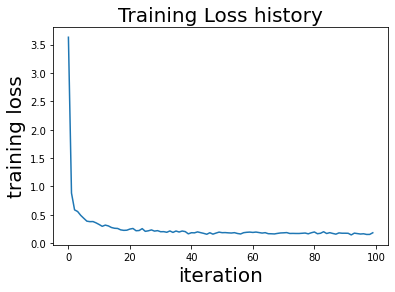

In [68]:
net = init_toy_model()
stats = net.train(X, y.reshape(-1,1), X, y.reshape(-1,1),
            learning_rate=1e-2, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration',size = 20)
plt.ylabel('training loss',size = 20)
plt.title('Training Loss history', size = 20)
plt.show()

#  Part III. Multi-layer NN

Now we have finished the top layer, and we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with various architectures.

## Affine layer: foward

In [69]:
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). 
    Reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """

##############################################################################
### TODO: Perform affine transformation.                                   ###
##############################################################################
    out = np.reshape(x,(x.shape[0],np.prod(x.shape[1:]))).dot(w) + b


##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################
    cache = (x, w, b)
    
    return out, cache

In [70]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 1

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.51506276],
                        [ 3.32259414]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  4.971001967190414e-10


## Affine layer: backward

In [71]:
def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache

##############################################################################
### TODO: Calculate the gradient of affine transformation                  ###
##############################################################################
    db = np.sum(dout, axis = 0)   
    dw = np.reshape(x,(x.shape[0],np.prod(x.shape[1:]))).T.dot(dout)
    dx = dout.dot(w.T).reshape(x.shape) 
    

##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################


    return dx, dw, db

In [72]:
from gradient_check import eval_numerical_gradient, eval_numerical_gradient_array


# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 1)
b = np.random.randn(1)
dout = np.random.randn(10, 1)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  6.87499785805733e-11
dw error:  5.93473398572531e-11
db error:  2.4097482260876687e-12


##  ReLU activation: forward

### ReLU
There are many potential choices for the nonlinear activation function (such
as sigmoid, hyperbolic, softmax). We use the same activation function at all
nodes, and choose a popular functional form in recent literature known as the
rectified linear unit (ReLU), defined as:

$$\text{ReLU}(x) = \begin{cases}0 \quad &\text{if}\; x < 0 \\
x \quad &\text{otherwise} \end{cases} $$

which encourages sparsity in the number of active neurons and allows for faster derivative evaluation.

Our neural network model has the following general formula. Let $K^{(l)}$ denote the number of neurons in each layer $l =1,...,L$. Define the output of neuron $k$ in layer $l$ as $x_{k}^{(l)}$. Next, define the vector of outputs for this layer (augmented to include a constant, $x_{0}^{(l)}$ ) as 
$x^{(l)} = (1,x_{1}^{(l)},...,x_{K^{l}}^{(l)})'$. 
To initialize the network, similarly define the input layer using the raw predictors, $x^{(0)} =(1,z_{1},...,z_{N})'$. The recursive output formula for the neural network at each neuron in layer $l>0$ is then

$$x_{k}^{(l)} =  \text{ReLU} \left( x^{(l-1)'} \;\theta_{k}^{(l-1)}\; \right)$$

with final output:

$$g(z;\theta) = x^{(L-1)'} \;\theta^{L-1}$$

The number of weight parameters in each hidden layer $l$ is $K^{(l)}\left(1+K^{(l−1)} \;\right)$, plus another $1+K^{(L−1)}$ weights for the output layer.

We estimate the neural network weight parameters by minimizing the penalized $l_{2}$ objective function of prediction errors. Unlike tree-based algorithms that require “greedy” optimization, training a neural network, in principle, allows for joint updates of all model parameters at each step of the optimization—a substantial advantage of neural networks over trees.

In [73]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).
    """
##############################################################################
### TODO: Calculate the gradient of affine transformation                  ###
##############################################################################
    out = np.maximum(x,0)
##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################
    cache = x
    return out, cache

In [74]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


## ReLU activation: backward

In [75]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of ReLUs.

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    
##############################################################################
### TODO: Calculate the gradient of affine transformation                  ###
##############################################################################
    dx = dout*(x>0)
##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################
    cache = x

    return dx

In [76]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Loss layers: MSE

In [77]:
def mean_square_loss(x, y):
    """
    Computes the loss and gradient for mean square loss.

    Inputs:
    - x: Shape (N, ) 
    - y: Shape (N,)
    
    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    
##############################################################################
### TODO: Calculate the loss and gradient for MSE.                         ###
##############################################################################

    loss = np.mean((x- y)**2)
    dx = 2*x/x.shape[0]
    

##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################

    return loss, dx

In [78]:
np.random.seed(231)
num_output, num_inputs = 1, 50
x = 0.001 * np.random.randn(num_inputs, num_output)
y = np.random.randint(num_output, size=num_inputs).reshape(-1,1)

dx_num = eval_numerical_gradient(lambda x: mean_square_loss(x, y)[0], x, verbose=False)
loss, dx = mean_square_loss(x, y)

# Test mean_square_loss function. Loss should be close to 2.3 and dx error should be around e-8
# According to Ed, the loss is close to e-7 and dx error is close to e-12
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))


Testing softmax_loss:
loss:  7.717948769472712e-07
dx error:  4.4933157641170004e-12


## Combine the above blocks and build a neural network

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-7 or less.

In [79]:
class FullyConnectedNet(object):
    """
    A fully-connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and a mean square loss function. For a network with L layers,
    the architecture will be

    {affine - [batch/layer norm] - relu - [dropout]} x (L - 1) - affine - mean_square

    where batch/layer normalization and dropout are optional, and the {...} block is
    repeated L - 1 times.

    Learnable parameters are stored in the
    self.params dictionary and will be learned using the Solver class.
    """

    def __init__(self, hidden_dims, input_dim=100, num_output=1,
                 reg=0.0,
                 weight_scale=1e-2, dtype=np.float32):
        """
        Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_output: For regression, num_output = 1
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
          this datatype. float32 is faster but less accurate, so you should use
          float64 for numeric gradient checking.

        """
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        if len(hidden_dims)>0:
            self.params['W1'] = weight_scale * np.random.randn(input_dim, hidden_dims[0])
            self.params['b1'] = np.zeros(hidden_dims[0])
        
        for idx, dim in enumerate(hidden_dims):
            if idx < len(hidden_dims)-1:
                self.params['W' + str(2 + idx)] = weight_scale * np.random.randn(dim, hidden_dims[idx + 1])
                self.params['b' + str(2 + idx)] = np.zeros(hidden_dims[idx + 1])
            else:
                self.params['W' + str(2 + idx)] = weight_scale * np.random.randn(hidden_dims[idx], num_output)
                self.params['b' + str(2 + idx)] = np.zeros(num_output)


        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.

        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype)
        mode = 'test' if y is None else 'train'

        out = X
        for la in range(self.num_layers-1):
            a, _      = affine_forward(out, self.params['W'+str(la+1)], self.params['b'+str(la+1)])
            out, _    = relu_forward(a)
            

            
        scores, _ = affine_forward(out,
                                   self.params['W'+str(self.num_layers)],self.params['b'+str(self.num_layers)])


        # If test mode return early
        if mode == 'test':
            return scores

        out = X
        a=[]
        affine_cache = []
        relu_cache   = []
       
        
        loss, grads = 0.0, {}
        
        for la in range(self.num_layers-1):
            a, a_cache    = affine_forward(out, self.params['W'+str(la+1)], self.params['b'+str(la+1)])
            affine_cache.append(a_cache)
                
            out, r_cache    = relu_forward(a)
            relu_cache.append(r_cache)
            
   
        scores, cache  = affine_forward(out, self.params['W'+str(self.num_layers)], self.params['b'+str(self.num_layers)])
        loss, dx       = mean_square_loss(scores, y)
        
        
    
        da, dW, db  = affine_backward(dx, cache)
        grads['W'+str(self.num_layers)] = dW
        grads['b'+str(self.num_layers)] = db
        
            
        for la in reversed(range(self.num_layers-1)):            
            
            dr = relu_backward(da, relu_cache[la])
            
            da, dW, db = affine_backward(dr, affine_cache[la])
            grads['W'+ str(la+1)] = dW
            grads['b'+ str(la+1)] = db
            
        for la in range(self.num_layers):
            loss += 1/2*self.reg * np.sum(self.params['W'+ str(la+1)] * self.params['W'+ str(la+1)])     
            grads['W'+ str(la+1)]  +=  self.reg*self.params['W'+ str(la+1)] 

        return loss, grads



In [ ]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 1
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,)).reshape(-1,1)

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_output=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Most of the errors should be on the order of e-7 or smaller.   
  # for the check when reg = 0.0
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

# Part IV. Return prediction

The simulation result in `Simu` file. It contains 100 time Monte Carlo simulation experiment, each with firm characteristics, linear and non-linear return.

In [ ]:
# Setup codes

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Run the following cells to load the data. You can choose different i here.

In [ ]:
i = str(100)
if "c100.csv" not in path: 
    path = "" # This is for running code locally

factor = np.array(pd.read_csv(path+'c'+i+'.csv'))
linear_ret = np.array(pd.read_csv(path+'r1_'+i+'_1.csv'))
nonlinear_ret = np.array(pd.read_csv(path+'r2_'+i+'_1.csv'))

With the above preparation, build a NN using linear and non-linear return. And compare the results with 
+ OLS, 
+ OLS + Regularization (L1,L2),
+ Tree model(CART+Random Forest).

What conclusions can you make? (You can use some visualziation tools to help you illustrate your results)

### Neural network

Here is a NN example with subsample dataset. Once you finish all the cells above. You can directly run the below cells to get the prediction result. You don't need to modify any codes here.

In [ ]:
# NN with sample data

from solver import Solver

num_train = 2500
num_valid = 500
small_data = {
  'X_train': factor[:num_train],
  'y_train': nonlinear_ret[:num_train],
  'X_val': factor[num_train:num_train+num_valid],
  'y_val': nonlinear_ret[num_train:num_train+num_valid]
}

learning_rate = 5e-2  # Experiment with this!
weight_scale = 1*1e-1   # Experiment with this!
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now follow the same framework shown in the subsample data, train the NN with full sample data.Try to tune the parameters and construct the neural network with different numbers of layers. Compare their results.

(Iteration 1 / 18140) loss: 0.011615
(Epoch 0 / 20) train loss: 0.020859; val_loss: 0.021267
(Iteration 11 / 18140) loss: 0.012777
(Iteration 21 / 18140) loss: 0.013154
(Iteration 31 / 18140) loss: 0.014473
(Iteration 41 / 18140) loss: 0.008970
(Iteration 51 / 18140) loss: 0.008179
(Iteration 61 / 18140) loss: 0.010930
(Iteration 71 / 18140) loss: 0.010102
(Iteration 81 / 18140) loss: 0.012127
(Iteration 91 / 18140) loss: 0.006702
(Iteration 101 / 18140) loss: 0.009234
(Iteration 111 / 18140) loss: 0.005706
(Iteration 121 / 18140) loss: 0.008110
(Iteration 131 / 18140) loss: 0.005822
(Iteration 141 / 18140) loss: 0.013777
(Iteration 151 / 18140) loss: 0.006142
(Iteration 161 / 18140) loss: 0.005540
(Iteration 171 / 18140) loss: 0.006090
(Iteration 181 / 18140) loss: 0.009194
(Iteration 191 / 18140) loss: 0.007326
(Iteration 201 / 18140) loss: 0.010158
(Iteration 211 / 18140) loss: 0.008589
(Iteration 221 / 18140) loss: 0.008410
(Iteration 231 / 18140) loss: 0.006916
(Iteration 241 / 18

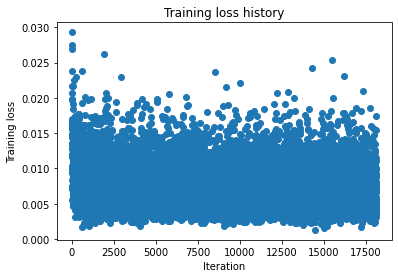

In [81]:
# NN with full data


##############################################################################
### TODO: NN with full data.                                               ###
##############################################################################
from solver import Solver
from sklearn.model_selection import train_test_split

# factor.shape has (36000,100)


# First split data into (traning + validation) 90 % vs testing 10%
X_temp, X_test, y_temp, y_test = train_test_split(factor, nonlinear_ret, test_size=0.1, random_state=0)

# First split data into traning 70% vs testing 30%
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=0)

small_data = {
  'X_train': X_train,
  'y_train': y_train,
  'X_val': X_val,
  'y_val': y_val
}


learning_rate = 5e-2  # Experiment with this!
weight_scale = 1*1e-1   # Experiment with this!
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()
##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################



In [ ]:
# Now search for the optimal learning_rates and weight_scales
learning_rates = [5e-2,5e-3]
weight_scales = [1e-5, 1e-3, 1e-1]

# Temp for best parameters and models
best_val_loss = np.inf  
best_solver = None 
best_params = None
small_data = {
  'X_train': X_train,
  'y_train': y_train,
  'X_val': X_val,
  'y_val': y_val
}

# Subplots of learning history loss
n_plots = len(learning_rates) * len(weight_scales)
n_cols = len(weight_scales)  
n_rows = len(learning_rates)  

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*5, n_rows*4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust space between plots

for i, lr in enumerate(learning_rates):
    for j, ws in enumerate(weight_scales):
        ax = axes[i, j]  

        model = FullyConnectedNet([100, 100, 100, 100], weight_scale=ws, dtype=np.float64)
        solver = Solver(model, small_data,
                        print_every=10000, num_epochs=20, batch_size=25,
                        update_rule='sgd',
                        optim_config={
                          'learning_rate': lr,
                        },
                        verbose=False 
                )
        solver.train()

        ax.plot(solver.loss_history, 'o')
        ax.set_title(f'Training Loss LR: {lr}, WS: {ws}')  
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Training loss')
        # Keep track of the best model with in OOS MSE with validation set
        # After training, access the best parameters and minimized squared loss
        min_val_loss = solver.best_val_loss
        if min_val_loss < best_val_loss:
          best_solver = solver
          best_val_loss = min_val_loss
          best_params = solver.best_params

plt.show()
# Print the results
print("Minimized Validation Loss:", min_val_loss)
print("Best Model Parameters:", best_params)


y_test_pred = model.loss(X_test)  # Assuming your model's loss function can also make predictions
test_loss = np.mean((y_test_pred - y_test) ** 2)  # Calculate test set MSE
print("Test Set Mean Squared Error:", test_loss)



In [ ]:
y_test_pred = solver.model.loss(X_test)
test_mse = np.mean((y_test_pred - y_test) ** 2)
print('Test MSE:', test_mse)

### Linear model and its variants

Construct the linear regression model, with different regularization method, perform the above prediction task. Compare their results.

In [ ]:
##############################################################################
### TODO: Linear model and its variants.                                   ###
##############################################################################

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# Initialize parameter
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.1)
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)


ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)
elastic_net.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso.predict(X_test)
y_pred_elastic_net = elastic_net.predict(X_test)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mse_elastic_net = mean_squared_error(y_test, y_pred_elastic_net)

print("MSE for Ridge Regression:", mse_ridge)
print("MSE for Lasso Regression:", mse_lasso)
print("MSE for Elastic Net Regression:", mse_elastic_net)
##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################


In [80]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for each model
param_grid_ridge = {'alpha': np.logspace(-4, 4, 20)}
param_grid_lasso = {'alpha': np.logspace(-4, 4, 20)}
param_grid_elastic_net = {'alpha': np.logspace(-4, 4, 20), 'l1_ratio': np.arange(0.0, 1.0, 0.1)}

# Initialize the models
ridge = Ridge()
lasso = Lasso()
elastic_net = ElasticNet()

# Set up the grid search for each model
grid_search_ridge = GridSearchCV(ridge, param_grid_ridge, scoring='neg_mean_squared_error', cv=5)
grid_search_lasso = GridSearchCV(lasso, param_grid_lasso, scoring='neg_mean_squared_error', cv=5)
grid_search_elastic_net = GridSearchCV(elastic_net, param_grid_elastic_net, scoring='neg_mean_squared_error', cv=5)

# Fit the grid search to the data
grid_search_ridge.fit(X_train, y_train)
grid_search_lasso.fit(X_train, y_train)
grid_search_elastic_net.fit(X_train, y_train)

# Retrieve the best model from the grid search
best_ridge = grid_search_ridge.best_estimator_
best_lasso = grid_search_lasso.best_estimator_
best_elastic_net = grid_search_elastic_net.best_estimator_

# Predict and calculate MSE for each model using the test set
y_pred_ridge = best_ridge.predict(X_test)
y_pred_lasso = best_lasso.predict(X_test)
y_pred_elastic_net = best_elastic_net.predict(X_test)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mse_elastic_net = mean_squared_error(y_test, y_pred_elastic_net)

# Print the best parameters and MSE for each model
print("Best parameters for Ridge Regression:", grid_search_ridge.best_params_)
print("MSE for Ridge Regression:", mse_ridge)
print("Best parameters for Lasso Regression:", grid_search_lasso.best_params_)
print("MSE for Lasso Regression:", mse_lasso)
print("Best parameters for Elastic Net Regression:", grid_search_elastic_net.best_params_)
print("MSE for Elastic Net Regression:", mse_elastic_net)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.983e+01, tolerance: 1.332e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.920e+01, tolerance: 1.316e-02 Linear regression models with null weight for the l1 regularization term are more ef

KeyboardInterrupt: 

### Tree based model

Now construct the tree model (CART, Random Forest) and redo the above exercise. Compare their results.

In [89]:
##############################################################################
### TODO: Tree based models.                                               ###
##############################################################################

# CART
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score


max_depth = [3,4,5,6,7]
min_sample_leaf = [5,10,15]

best_cart = None
best_MSE_cart = np.inf
best_depth = 0
best_leaf = 0

for i,depth in enumerate(max_depth):
    for j, leaf in enumerate(min_sample_leaf):
        cart_model = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=leaf)
        cart_model.fit(X_train, y_train)
        y_val_pred = cart_model.predict(X_val)
        val_mse = np.mean((y_val_pred - y_val) ** 2)
        if val_mse < best_MSE_cart:
            best_cart = cart_model
            best_MSE_cart = val_mse
            best_depth = depth
            best_leaf = leaf


# Rebuild cart model using the best parameter with the entire (validation & training) data
cart_fit = DecisionTreeRegressor(max_depth=best_depth, min_samples_leaf=best_leaf)
cart_fit.fit(X_temp, y_temp)
y_test_cart_pred = cart_model.predict(X_test)
test_mse_cart = np.mean((y_test_pred - y_test) ** 2)
r2_cart = r2_score(y_test, y_test_cart_pred)
print(f"Best Decision Tree (CART) parameters - Max Depth: {best_depth}, Min Samples Leaf: {best_leaf}")
print("MSE for CART:", test_mse_cart)
print("r2 score for CART:", r2_cart)

Best Decision Tree (CART) parameters - Max Depth: 3, Min Samples Leaf: 10
MSE for CART: 0.007646546274330604


In [88]:
from sklearn.ensemble import RandomForestRegressor
# Train random forest for regression
rf_model = RandomForestRegressor(max_depth=3, min_samples_leaf=10, random_state=0, n_estimators=100)
rf_model.fit(X_train, y_train.ravel())  


y_val_pred = rf_model.predict(X_val)
val_mse = mean_squared_error(y_val.ravel(), y_val_pred)  
print("Validation MSE:", val_mse)


y_test_rf_pred = rf_model.predict(X_test)
test_mse_rf = mean_squared_error(y_test.ravel(), y_test_rf_pred) 
print("Test MSE for Random Forest:", test_mse_rf)

Validation MSE: 0.006978230454509004
Test MSE for Random Forest: 0.006848298378742279


In [91]:
rf_model = RandomForestRegressor(max_depth=4, min_samples_leaf=10, random_state=0, n_estimators=100)
rf_model.fit(X_train, y_train.ravel())  


y_val_pred = rf_model.predict(X_val)
val_mse = mean_squared_error(y_val.ravel(), y_val_pred)  
print("Validation MSE:", val_mse)


y_test_rf_pred = rf_model.predict(X_test)
test_mse_rf = mean_squared_error(y_test.ravel(), y_test_rf_pred) 
print("Test MSE for Random Forest:", test_mse_rf)

Validation MSE: 0.0069073033454229256
Test MSE for Random Forest: 0.006808022398863499


In [ ]:
rf_model = RandomForestRegressor(max_depth=5, min_samples_leaf=10, random_state=0, n_estimators=100)
rf_model.fit(X_train, y_train.ravel())  


y_val_pred = rf_model.predict(X_val)
val_mse = mean_squared_error(y_val.ravel(), y_val_pred)  
print("Validation MSE:", val_mse)


y_test_rf_pred = rf_model.predict(X_test)
test_mse_rf = mean_squared_error(y_test.ravel(), y_test_rf_pred) 
print("Test MSE for Random Forest:", test_mse_rf)

In [92]:
from sklearn.ensemble import RandomForestRegressor

# Hyperparameters to search
max_depth = [3, 4, 5, 6, 7]
min_samples_leaf = [10]

# Variables to store the best model and its performance metrics
best_rf = None
best_MSE_rf = np.inf
best_depth_rf = 0
best_leaf_rf = 0

# Grid search for the best model parameters
for depth in max_depth:
    for leaf in min_samples_leaf:
        rf_model = RandomForestRegressor(max_depth=depth, min_samples_leaf=leaf, random_state=0, n_estimators=100)
        rf_model.fit(X_train, y_train.ravel())  
        y_val_pred = rf_model.predict(X_val)
        val_mse = mean_squared_error(y_val.ravel(), y_val_pred)  
        if val_mse < best_MSE_rf:
            best_rf = rf_model
            best_MSE_rf = val_mse
            best_depth_rf = depth
            best_leaf_rf = leaf

# Using the best model to predict on the test set
y_test_rf_pred = best_rf.predict(X_test)
test_mse_rf = mean_squared_error(y_test.ravel(), y_test_rf_pred)  
r2_rf = r2_score(y_test, y_test_rf_pred)  

# Print out the best parameters and performance metrics
print(f"Best Random Forest parameters - Max Depth: {best_depth_rf}, Min Samples Leaf: {best_leaf_rf}")
print(f"OOS MSE for Random Forest: {test_mse_rf}")
print(f"OOS R² for Random Forest: {r2_rf}")



##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################

Best Random Forest parameters - Max Depth: 6, Min Samples Leaf: 10
OOS MSE for Random Forest: 0.006787873493302552
OOS R² for Random Forest: 0.07371002975438024


## Results

Compare the above findings and write your results here.